# Notebook Final del PFM
## Título: Comparativa de algoritmos de clustering sobre datos de futbolistas de las grandes ligas europeas.
## Tutor: Miguel Camacho

Los datos se han obtenido de fbref.com. Están compuestos de 128 jugadores ofensivos que han participado en las últimas cinco temporadas de forma ininterrumpida en las cinco grandes ligas europeas de fútbol (Premier League, LaLiga, Serie A, Bundesliga y Ligue 1). 



# Importar Librerías

In [3]:
!pip install pandas-profiling==2.7.1
!pip install pandas==1.2.4
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import sys, getopt
import csv
import pandas_profiling
import numpy as np
from sklearn import preprocessing
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

Mounted at /content/drive


# Definir constantes y funciones auxiliares

In [4]:
class Summary:
  START_HEADER = 9
  N_COLUMNS = 38
  END_HEADER = START_HEADER + N_COLUMNS
  FIELDS_SUMMARY = ['Date','Day','Comp','Round','Venue','Result',
                    'Squad','Opponent','Start','Pos','Min','Gls','Ast','PK',
                    'PKatt','Sh','SoT','CrdY','CrdR','Touches','Press','Tkl',
                    'Int','Blocks','xG','npxG','xA','SCA','GCA','Cmp','Att',
                    'CmpPerc','Prog','Carries','Prog','Succ','Att',
                    'Match Report','Player']
  FIELDS_MERGE_SUMMARY = ['Gls', 'PK', 'PKatt', 'Sh', 'SoT', 'xG', 'npxG']

class Passing:
  START_HEADER = 8
  N_COLUMNS = 33
  END_HEADER = START_HEADER + N_COLUMNS
  FIELDS_PASSING = ['Date','Day','Comp','Round','Venue','Result',
                    'Squad','Opponent','Start','Pos','Min','TotCmp','TotAtt',
                    'TotCmpPerc','TotDist','PrgDist','ShCmp','ShAtt',
                    'ShCmpPerc','MedCmp','MedAtt','MedCmpPerc','LongCmp',
                    'LongAtt','LongCmpPerc','Ast','xA','KP','1/3','PPA','CrsPA',
                    'Prog','Match Report','Player']

class Pass_Types:
  START_HEADER = 9
  N_COLUMNS = 37
  END_HEADER = START_HEADER + N_COLUMNS
  FIELDS_PASS_TYPES = ['Date','Day','Comp','Round','Venue','Result',
                       'Squad','Opponent','Start','Pos','Min','Att','Live',
                       'Dead','FK','TB','Press','Sw','Crs','CK','InCK','OutCK',
                       'StrCK','GroundPass','LowPass','HighPass','LeftPass',
                       'RightPass','HeadPass','TI','Other','CmpPass','OffSide',
                       'Out','IntPass','BlockPass','Match Report','Player']

class GCA:
  START_HEADER = 5
  N_COLUMNS = 26
  END_HEADER = START_HEADER + N_COLUMNS
  FIELDS_GCA = ['Date','Day','Comp','Round','Venue','Result','Squad',
                'Opponent','Start','Pos','Min','SCA','PassLiveSCA',
                'PassDeadSCA','DribSCA','ShSCA','FldSCA','DefSCA','GCA',
                'PassLiveGCA','PassDeadGCA','DribGCA','ShGCA','FldGCA',
                'DefGCA','Match Report','Player']

class Defensive:
  START_HEADER = 7
  N_COLUMNS = 35
  END_HEADER = START_HEADER + N_COLUMNS
  FIELDS_DEFENSIVE = ['Date','Day','Comp','Round','Venue','Result',
                      'Squad','Opponent','Start','Pos','Min','Tkl','TklW',
                      'Def3rdTkl','Mid3rdTkl','Att3rdTkl','TklDrib',
                      'TklDribAtt','TklDribPerc','TklDribPast','PressAtt',
                      'PressSucc','PressPerc','Def3rdPress','Mid3rdPress',
                      'Att3rdPress','Blocks','ShBlock','ShSvBlock','PassBlock',
                      'Int','Tkl+Int','Clr','Err','Match Report','Player']

class Possession:
  START_HEADER = 7
  N_COLUMNS = 36
  END_HEADER = START_HEADER + N_COLUMNS
  FIELDS_POSSESSION = ['Date','Day','Comp','Round','Venue','Result',
                       'Squad','Opponent','Start','Pos','Min','Touches',
                       'DefPenTouches','Def3rdTouches','Mid3rdTouches',
                       'Att3rdTouches','AttPenTouches','LiveTouches',
                       'SuccDrib','AttDrib','SuccDribPerc','NuPlDrib',
                       'Nutmegs','Carries','TotDistCarries','PrgDistCarries',
                       'ProgCarries','1/3Carries','CPA','MisCarries',
                       'DisCarries','TargPass','RecPass','RecPassPerc',
                       'ProgPassRec','Match Report','Player']

class Miscellaneous:
  START_HEADER = 5
  N_COLUMNS = 28
  END_HEADER = START_HEADER + N_COLUMNS
  FIELDS_MISC = ['Date','Day','Comp','Round','Venue','Result','Squad',
                 'Opponent','Start','Pos','Min','CrdY','CrdR','2CrdY','FlsComm',
                 'FlsDrawn','Offsides','Crs','Int','TklW','PKwon','PKcon','OG',
                 'Recov','AerialDuelsWon','AerialDuelsLost',
                 'AerialDuelsWinPerc','Match Report', 'Player']
  FIELDS_MERGE_MISC = ['CrdY', 'CrdR', '2CrdY', 'FlsComm', 'FlsDrawn', 
                       'Offsides', 'PKwon', 'PKcon', 'OG', 'Recov', 
                       'AerialDuelsWon', 'AerialDuelsLost', 
                       'AerialDuelsWinPerc', 'Match Report']


class Global:
  START_DATA = 2
  KEY = ['Player', 'Date', 'Day', 'Comp', 'Round', 'Venue', 'Result', 'Squad', 
       'Opponent', 'Start', 'Pos', 'Min']
  TYPES = ['summary', 'passing', 'passing_types', 'gca', 'defense', 
           'possession', 'misc']
  DICT_TYPES = {'summary': Summary, 'passing': Passing, 
                'passing_types': Pass_Types, 'gca': GCA, 
                'defense': Defensive, 'possession': Possession, 
                'misc': Miscellaneous}
  SEASONS = ['2021-2022', '2020-2021', '2019-2020', '2018-2019', '2017-2018']
  DICT_PLAYERS = {
      'Karim Benzema': 'https://fbref.com/en/players/70d74ece/matchlogs/',
      'Lionel Messi': 'https://fbref.com/en/players/d70ce98e/matchlogs/',
      'Kylian Mbappe': 'https://fbref.com/en/players/42fd9c7f/matchlogs/',
      'Memphis Depay': 'https://fbref.com/en/players/8f696594/matchlogs/',
      'Duvan Zapata': 'https://fbref.com/en/players/d3de9af0/matchlogs/',
      'Luis Muriel': 'https://fbref.com/en/players/eb2fe5b6/matchlogs/',
      'Robert Lewandowski': 'https://fbref.com/en/players/8d78e732/matchlogs/',
      'Gerard Moreno': 'https://fbref.com/en/players/81f0781e/matchlogs/',
      'Cristiano Ronaldo': 'https://fbref.com/en/players/dea698d9/matchlogs/',
      'Harry Kane': 'https://fbref.com/en/players/21a66f6a/matchlogs/',
      'Paulo Dybala': 'https://fbref.com/en/players/e0921a4f/matchlogs/',
      'Antoine Griezmann': 'https://fbref.com/en/players/df69b544/matchlogs/',
      'Roberto Firmino': 'https://fbref.com/en/players/4c370d81/matchlogs/',
      'Dimitri Payet': 'https://fbref.com/en/players/58ae47b2/matchlogs/',
      'Iago Aspas': 'https://fbref.com/en/players/7dcf86f6/matchlogs/',
      'Marco Reus': 'https://fbref.com/en/players/36a3ff67/matchlogs/',
      'Kingsley Coman': 'https://fbref.com/en/players/042e8a49/matchlogs/',
      'Angel Di Maria': 'https://fbref.com/en/players/19cda00b/matchlogs/',
      'Leroy Sane': 'https://fbref.com/en/players/2b114be3/matchlogs/',
      'Neymar': 'https://fbref.com/en/players/69384e5d/matchlogs/',
      'Riyad Mahrez': 'https://fbref.com/en/players/892d5bb1/matchlogs/',
      'Nabil Fekir': 'https://fbref.com/en/players/bece776f/matchlogs/',
      'Serge Gnabry': 'https://fbref.com/en/players/88e357ef/matchlogs/',
      'Erik Lamela': 'https://fbref.com/en/players/abe66106/matchlogs/',
      'Nicolas Pepe': 'https://fbref.com/en/players/57e3f0c7/matchlogs/',
      'Christopher Nkunku': 'https://fbref.com/en/players/7c56da38/matchlogs/',
      'Phil Foden': 'https://fbref.com/en/players/ed1e53f3/matchlogs/',
      'Roberto Firmino': 'https://fbref.com/en/players/4c370d81/matchlogs/',
      'Dimitri Payet': 'https://fbref.com/en/players/58ae47b2/matchlogs/',
      'Angel Correa': 'https://fbref.com/en/players/01eb744d/matchlogs/',
      'Federico Chiesa': 'https://fbref.com/en/players/b0f7e36c/matchlogs/',
      'Sadio Mane': 'https://fbref.com/en/players/c691bfe2/matchlogs/',
      'Wissam Ben Yedder': 'https://fbref.com/en/players/942b4f90/matchlogs/',
      'Breel Embolo': 'https://fbref.com/en/players/0b4f388a/matchlogs/',
      'Alexandre Lacazette': 'https://fbref.com/en/players/9dbb75ca/matchlogs/',
      'Alvaro Morata': 'https://fbref.com/en/players/129af0db/matchlogs/',
      'Gabriel Jesus': 'https://fbref.com/en/players/b66315ae/matchlogs/',
      'Ciro Immobile': 'https://fbref.com/en/players/4431aed2/matchlogs/',
      'Romelu Lukaku': 'https://fbref.com/en/players/5eae500a/matchlogs/',
      'Edin Dzeko': 'https://fbref.com/en/players/3bb7f478/matchlogs/',
      'Andre Silva': 'https://fbref.com/en/players/3effaa34/matchlogs/',
      'Timo Werner':'https://fbref.com/en/players/49fe9070/matchlogs/',
      'Patrik Schick': 'https://fbref.com/en/players/5d4f7d61/matchlogs/',
      'Andy Delort': 'https://fbref.com/en/players/d33c706e/matchlogs/',
      'Luis Suarez': 'https://fbref.com/en/players/a6154613/matchlogs/',
      'Carlos Bacca': 'https://fbref.com/en/players/09a9e921/matchlogs/',
      'Rodrigo': 'https://fbref.com/en/players/1fb1c435/matchlogs/',
      'Gareth Bale': 'https://fbref.com/en/players/a58bb1e1/matchlogs/',
      'Antonio Sanabria': 'https://fbref.com/en/players/0a447501/matchlogs/',
      'Kike': 'https://fbref.com/en/players/e897d8ba/matchlogs/',
      'Inaki Williams': 'https://fbref.com/en/players/6a99e0b1/matchlogs/',
      'Jamie Vardy': 'https://fbref.com/en/players/45963054/matchlogs/',
      'Paco Alcacer': 'https://fbref.com/en/players/a7a9d95a/matchlogs/',
      'Edinson Cavani': 'https://fbref.com/en/players/527f063d/matchlogs/',
      'Willian Jose': 'https://fbref.com/en/players/d87e2cae/matchlogs/',
      'Joao Pedro': 'https://fbref.com/en/players/81255c03/matchlogs/',
      'Kevin Lasagna': 'https://fbref.com/en/players/09538fdb/matchlogs/',
      'Fabio Quagliarella': 'https://fbref.com/en/players/ee4f2f3b/matchlogs/',
      'Lucas Perez': 'https://fbref.com/en/players/a300ac7e/matchlogs/',
      'Manolo Gabbiadini': 'https://fbref.com/en/players/8f866fe8/matchlogs/',
      'Roger Marti': 'https://fbref.com/en/players/0ae4e09a/matchlogs/',
      'Danny Ings': 'https://fbref.com/en/players/07802f7f/matchlogs/',
      'Ruben Sobrino': 'https://fbref.com/en/players/19b776e9/matchlogs/',
      'Raul Garcia': 'https://fbref.com/en/players/b418dbd4/matchlogs/',
      'Richarlison': 'https://fbref.com/en/players/fa031b34/matchlogs/',
      'Maxi Gomez': 'https://fbref.com/en/players/4c2e9442/matchlogs/',
      'Jorge Molina': 'https://fbref.com/en/players/43f71e77/matchlogs/',
      'Joselu': 'https://fbref.com/en/players/6265208f/matchlogs/',
      'Mattia Destro': 'https://fbref.com/en/players/d7d32194/matchlogs/',
      'Youssef En-Nesyri': 'https://fbref.com/en/players/04e17fd5/matchlogs/',
      'Olivier Giroud': 'https://fbref.com/en/players/16ceb862/matchlogs/',
      'Santi Mina': 'https://fbref.com/en/players/0b90bb97/matchlogs/',
      'Chris Wood': 'https://fbref.com/en/players/4e9a0555/matchlogs/',
      'Enes Unal': 'https://fbref.com/en/players/f8eca1b6/matchlogs/',
      'Leonardo Pavoletti': 'https://fbref.com/en/players/d37b0350/matchlogs/',
      'Giovanni Simeone': 'https://fbref.com/en/players/343c0d52/matchlogs/',
      'Christian Benteke': 'https://fbref.com/en/players/ab070c55/matchlogs/',
      'Dominic Calvert Lewin': 'https://fbref.com/en/players/59e6e5bf/matchlogs/',
      'Callum Wilson': 'https://fbref.com/en/players/c596fcb0/matchlogs/',
      'Keita Balde': 'https://fbref.com/en/players/509a4ccb/matchlogs/',
      'Edinson Cavani': 'https://fbref.com/en/players/527f063d/matchlogs/',
      'Mauro Icardi': 'https://fbref.com/en/players/43b78598/matchlogs/',
      'Arkadiusz Milik': 'https://fbref.com/en/players/85613cf0/matchlogs/',
      'Sehrou Guirassy': 'https://fbref.com/en/players/923f4dda/matchlogs/',
      'Angel Rodriguez': 'https://fbref.com/en/players/8cfc2f69/matchlogs/',
      'Munir-El-Haddadi': 'https://fbref.com/en/players/8696bc90/matchlogs/',
      'Mikel Oyarzabal': 'https://fbref.com/en/players/8c3c640c/matchlogs/',
      'Alex Berenguer': 'https://fbref.com/en/players/dc1c2fce/matchlogs/',
      'Henrikh Mkhitaryan': 'https://fbref.com/en/players/dd0daf32/matchlogs/',
      'Ivan Perisic': 'https://fbref.com/en/players/6fe90922/matchlogs/',
      'Pedro': 'https://fbref.com/en/players/3ca7254a/matchlogs/',
      'Raheem Sterling': 'https://fbref.com/en/players/b400bde0/matchlogs/',
      'Federico Bernardeschi': 'https://fbref.com/en/players/ee93c1a9/matchlogs/',
      'Antonio Candreva': 'https://fbref.com/en/players/356c9002/matchlogs/',
      'Hakan Calhanoglu': 'https://fbref.com/en/players/cd0fa27b/matchlogs/',
      'Jadon Sancho': 'https://fbref.com/en/players/dbf053da/matchlogs/',
      'Lorenzo Insigne': 'https://fbref.com/en/players/2f557579/matchlogs/',
      'Adnan Januzaj': 'https://fbref.com/en/players/4737cebe/matchlogs/',
      'Nathan Redmond': 'https://fbref.com/en/players/ab651565/matchlogs/',
      'Vincenzo Grifo': 'https://fbref.com/en/players/54e4866f/matchlogs/',
      'Iker Muniain': 'https://fbref.com/en/players/c05dfb74/matchlogs/',
      'Jordan Ayew': 'https://fbref.com/en/players/da052c14/matchlogs/',
      'Lucas Ocampos': 'https://fbref.com/en/players/a08b974a/matchlogs/',
      'Ludovic Blas': 'https://fbref.com/en/players/6191093d/matchlogs/',
      'Wilfried Zaha': 'https://fbref.com/en/players/b2bc3b1f/matchlogs/',
      'Lucas Moura': 'https://fbref.com/en/players/2b622f01/matchlogs/',
      'Papu Gomez': 'https://fbref.com/en/players/6e4df551/matchlogs/',
      'Suso': 'https://fbref.com/en/players/4e219ad2/matchlogs/',
      'Dele Alli': 'https://fbref.com/en/players/cea4ee8f/matchlogs/',
      'Xherdan Shaqiri': 'https://fbref.com/en/players/6421ec64/matchlogs/',
      'Son Heung-min': 'https://fbref.com/en/players/92e7e919/matchlogs/',
      'Mohamed Salah': 'https://fbref.com/en/players/e342ad68/matchlogs/',
      'Marcus Rashford': 'https://fbref.com/en/players/a1d5bd30/matchlogs/',
      'Ferran Torres': 'https://fbref.com/en/players/9e1035f8/matchlogs/',
      'Juanmi': 'https://fbref.com/en/players/84399660/matchlogs/',
      'Jose Luis Morales': 'https://fbref.com/en/players/4a478107/matchlogs/',
      'Kevin Volland': 'https://fbref.com/en/players/64f69877/matchlogs/',
      'Portu': 'https://fbref.com/en/players/1bda5842/matchlogs/',
      'Felipe Caicedo': 'https://fbref.com/en/players/93b891d1/matchlogs/',
      'Kelechi Iheanacho': 'https://fbref.com/en/players/c92e1a31/matchlogs/',
      'Simone Zaza': 'https://fbref.com/en/players/9592289a/matchlogs/',
      'Pierre-Emerick Aubameyang': 'https://fbref.com/en/players/d5dd5f1f/matchlogs/',
      'Borja Mayoral': 'https://fbref.com/en/players/64e8ed6d/matchlogs/',
      'Joaquin Correa': 'https://fbref.com/en/players/45b9b619/matchlogs/',
      'Andrej Kramaric': 'https://fbref.com/en/players/603cb947/matchlogs/',
      'Sandro Ramirez': 'https://fbref.com/en/players/833fb62e/matchlogs/',
      'Martin Braithwaite': 'https://fbref.com/en/players/fd771f95/matchlogs/',
      'Mariano': 'https://fbref.com/en/players/5c4dc0ff/matchlogs/',
      'Stevan Jovetic': 'https://fbref.com/en/players/f36c432f/matchlogs/',
      'Eden Hazard ': 'https://fbref.com/en/players/a39bb753/matchlogs/',
      'Anthony Martial': 'https://fbref.com/en/players/8b788c01/matchlogs/'
  }

In [5]:
## Scrape one type
def scrape(url, page_type):
  res = requests.get(url).text
  soup = BeautifulSoup(res, 'html.parser')
  table = soup.find('table', class_='min_width sortable stats_table min_width shade_zero')
  n_games = len(table.tbody.find_all('tr'))
  columns = []
  dates = []
  row = []
  for i, header in enumerate(table.find_all('th')):
    if i in range(page_type.START_HEADER, page_type.END_HEADER):
      columns.append(header.text)
    if i in range(page_type.END_HEADER, page_type.END_HEADER + n_games):
      dates.append(header.text)
  df = pd.DataFrame(columns=columns)
  for j, data in enumerate(table.find_all('tr')):
    if j in range(Global.START_DATA, Global.START_DATA + n_games):
      raw_data = data.find_all('td')
      for a in raw_data:
        row.append(a.text)
      row.insert(0, dates[j-Global.START_DATA])
      if len(row) == page_type.N_COLUMNS:
        new_row = pd.Series(row, index = df.columns)
        df = df.append(new_row, ignore_index=True)
      row.clear()
  df['Player'] = url.split('/')[-1].replace('-Match-Logs', '').replace('-',' ')
  return df

def get_result(result):
  if len(result.split(' ')) == 2:
    return result.split(' ')
  else:
    return [result[0], result[1:].replace(' ','')]

## Scrape all types
def scrape_all(player, season, global_url, types):
  urls = []
  keys_list = list(Global.DICT_TYPES)
  for typ in types:
    urls.append(global_url + season + '/' + typ + '/' + player.replace(' ','-') + '-Match-Logs')
  for i, url in enumerate(urls):
    if i == 0:
      df_summary = scrape(url, Global.DICT_TYPES[url.split('/')[8]])
      df_summary.rename(columns=dict(zip(df_summary.columns, 
                                         Summary.FIELDS_SUMMARY)), inplace=True)
    if i == 1:
      df_passing = scrape(url, Global.DICT_TYPES[url.split('/')[8]])
      df_passing.rename(columns=dict(zip(df_passing.columns, 
                                         Passing.FIELDS_PASSING)), inplace=True)
    if i == 2:
      df_pass_types = scrape(url, Global.DICT_TYPES[url.split('/')[8]])
      df_pass_types.rename(columns=dict(zip(df_pass_types.columns, 
                                      Pass_Types.FIELDS_PASS_TYPES)), 
                           inplace=True)
    if i == 3:
      df_gca = scrape(url, Global.DICT_TYPES[url.split('/')[8]])
      df_gca.rename(columns=dict(zip(df_gca.columns, 
                                     GCA.FIELDS_GCA)), inplace=True)
    if i == 4:
      df_defensive = scrape(url, Global.DICT_TYPES[url.split('/')[8]])
      df_defensive.rename(columns=dict(zip(
          df_defensive.columns, Defensive.FIELDS_DEFENSIVE)), inplace=True)
    if i == 5:
      df_possession = scrape(url, Global.DICT_TYPES[url.split('/')[8]])
      df_possession.rename(columns=dict(
          zip(df_possession.columns, Possession.FIELDS_POSSESSION)), 
          inplace=True)
    if i == 6:
      df_misc = scrape(url, Global.DICT_TYPES[url.split('/')[8]])
      df_misc.rename(columns=dict(zip(
          df_misc.columns, Miscellaneous.FIELDS_MISC)), inplace=True)

  df = df_summary[Global.KEY + Summary.FIELDS_MERGE_SUMMARY].merge(
                     df_passing, left_on=Global.KEY, right_on=Global.KEY)
  df = df.merge(df_pass_types, left_on=Global.KEY, right_on=Global.KEY)
  df = df.merge(df_gca, left_on=Global.KEY, right_on=Global.KEY)
  df = df.merge(df_defensive, left_on=Global.KEY, right_on=Global.KEY)
  df = df.merge(df_possession, left_on=Global.KEY, right_on=Global.KEY)
  df = df.merge(df_misc[Global.KEY + Miscellaneous.FIELDS_MERGE_MISC], 
                left_on=Global.KEY, right_on=Global.KEY)
  df = df.fillna(0)
  df['Start'] = df['Start'].apply(lambda x: 1 if x in ('Y', 'Y*') else 0)
  df['Opponent'] = df['Opponent'].apply(lambda x: x[2:] if x[0].islower() else x)
  df['Squad'] = df['Squad'].apply(lambda x: x[2:] if x[0].islower() else x)
  df['Result'] = df['Result'].apply(lambda x: get_result(x))
  df['Score'] = df['Result'].apply(lambda x: x[1])
  df['Result'] = df['Result'].apply(lambda x: x[0])
  df['Score'] = df['Score'].apply(lambda x: x.split('–'))
  df['Squad_Goals'] = df['Score'].apply(lambda x: x[0])
  df['Opponent_Goals'] = df['Score'].apply(lambda x: x[1])
  df = df.drop(columns=['Score', 'Match Report_x', 'Match Report_y'])
  return df

In [6]:
# RESULTADO
def result(df_points, i):
  return 0.3 if df_points.loc[i,'Result'] == 1 else -0.3 if df_points.loc[i,'Result'] == 3 else 0

# PASES TOTALES
def tot_pass(df_points, i):
  if df_points.loc[i,'TotAtt'] <= 20:
    return 0
  elif (df_points.loc[i,'TotAtt'] > 20) & (df_points.loc[i,'TotAtt'] <= 40):
    if df_points.loc[i,'TotCmpPerc'] <= 50:
      return -0.1
    elif (df_points.loc[i,'TotCmpPerc'] > 50) & (df_points.loc[i,'TotCmpPerc'] <= 60):
      return -0.05
    elif (df_points.loc[i,'TotCmpPerc'] > 60) & (df_points.loc[i,'TotCmpPerc'] <= 70):
      return 0
    elif (df_points.loc[i,'TotCmpPerc'] > 70) & (df_points.loc[i,'TotCmpPerc'] <= 80):
      return 0.025
    elif (df_points.loc[i,'TotCmpPerc'] > 80) & (df_points.loc[i,'TotCmpPerc'] <= 90):
      return 0.05
    else:
      return 0.1
  elif (df_points.loc[i,'TotAtt'] > 40) & (df_points.loc[i,'TotAtt'] <= 60):
    if df_points.loc[i,'TotCmpPerc'] <= 50:
      return -0.2
    elif (df_points.loc[i,'TotCmpPerc'] > 50) & (df_points.loc[i,'TotCmpPerc'] <= 60):
      return -0.1
    elif (df_points.loc[i,'TotCmpPerc'] > 60) & (df_points.loc[i,'TotCmpPerc'] <= 70):
      return 0
    elif (df_points.loc[i,'TotCmpPerc'] > 70) & (df_points.loc[i,'TotCmpPerc'] <= 80):
      return 0.05
    elif (df_points.loc[i,'TotCmpPerc'] > 80) & (df_points.loc[i,'TotCmpPerc'] <= 90):
      return 0.1
    else:
      return 0.2
  else:
    if df_points.loc[i,'TotCmpPerc'] <= 50:
      return -0.3
    elif (df_points.loc[i,'TotCmpPerc'] > 50) & (df_points.loc[i,'TotCmpPerc'] <= 60):
      return -0.15
    elif (df_points.loc[i,'TotCmpPerc'] > 60) & (df_points.loc[i,'TotCmpPerc'] <= 70):
      return 0
    elif (df_points.loc[i,'TotCmpPerc'] > 70) & (df_points.loc[i,'TotCmpPerc'] <= 80):
      return 0.075
    elif (df_points.loc[i,'TotCmpPerc'] > 80) & (df_points.loc[i,'TotCmpPerc'] <= 90):
      return 0.15
    else:
      return 0.3

# PASES EN CORTO
def short_pass(df_points, i):
  if df_points.loc[i,'ShortAtt'] <= 10:
    return 0
  elif (df_points.loc[i,'ShortAtt'] > 10) & (df_points.loc[i,'ShortAtt'] <= 25):
    if df_points.loc[i,'ShortCmpPerc'] <= 50:
      return -0.05
    elif (df_points.loc[i,'ShortCmpPerc'] > 50) & (df_points.loc[i,'ShortCmpPerc'] <= 70):
      return -0.025
    elif (df_points.loc[i,'ShortCmpPerc'] > 70) & (df_points.loc[i,'ShortCmpPerc'] <= 80):
      return 0
    elif (df_points.loc[i,'ShortCmpPerc'] > 80) & (df_points.loc[i,'ShortCmpPerc'] <= 90):
      return 0.025
    else:
      return 0.05
  elif (df_points.loc[i,'ShortAtt'] > 25) & (df_points.loc[i,'ShortAtt'] <= 50):
    if df_points.loc[i,'ShortCmpPerc'] <= 50:
      return -0.1
    elif (df_points.loc[i,'ShortCmpPerc'] > 50) & (df_points.loc[i,'ShortCmpPerc'] <= 70):
      return -0.05
    elif (df_points.loc[i,'ShortCmpPerc'] > 70) & (df_points.loc[i,'ShortCmpPerc'] <= 80):
      return 0
    elif (df_points.loc[i,'ShortCmpPerc'] > 80) & (df_points.loc[i,'ShortCmpPerc'] <= 90):
      return 0.05
    else:
      return 0.1
  else:
    if df_points.loc[i,'ShortCmpPerc'] <= 50:
      return -0.2
    elif (df_points.loc[i,'ShortCmpPerc'] > 50) & (df_points.loc[i,'ShortCmpPerc'] <= 70):
      return -0.1
    elif (df_points.loc[i,'ShortCmpPerc'] > 70) & (df_points.loc[i,'ShortCmpPerc'] <= 80):
      return 0
    elif (df_points.loc[i,'ShortCmpPerc'] > 80) & (df_points.loc[i,'ShortCmpPerc'] <= 90):
      return 0.1
    else:
      return 0.2

# PASES A MEDIA DISTANCIA
def mid_pass(df_points, i):
  if df_points.loc[i,'MedAtt'] <= 10:
    return 0
  elif (df_points.loc[i,'MedAtt'] > 10) & (df_points.loc[i,'MedAtt'] <= 25):
    if df_points.loc[i,'MedCmpPerc'] <= 50:
      return -0.05
    elif (df_points.loc[i,'MedCmpPerc'] > 50) & (df_points.loc[i,'MedCmpPerc'] <= 65):
      return -0.025
    elif (df_points.loc[i,'MedCmpPerc'] > 65) & (df_points.loc[i,'MedCmpPerc'] <= 75):
      return 0
    elif (df_points.loc[i,'MedCmpPerc'] > 75) & (df_points.loc[i,'MedCmpPerc'] <= 90):
      return 0.025
    else:
      return 0.05
  else:
    if df_points.loc[i,'MedCmpPerc'] <= 50:
      return -0.1
    elif (df_points.loc[i,'MedCmpPerc'] > 50) & (df_points.loc[i,'MedCmpPerc'] <= 65):
      return -0.05
    elif (df_points.loc[i,'MedCmpPerc'] > 65) & (df_points.loc[i,'MedCmpPerc'] <= 75):
      return 0
    elif (df_points.loc[i,'MedCmpPerc'] > 75) & (df_points.loc[i,'MedCmpPerc'] <= 90):
      return 0.05
    else:
      return 0.1

# PASES LARGOS
def long_pass(df_points, i):
  if df_points.loc[i,'LongAtt'] <= 10:
    return 0
  else:
    if df_points.loc[i,'LongCmpPerc'] <= 50:
      return -0.1
    elif (df_points.loc[i,'LongCmpPerc'] > 65) & (df_points.loc[i,'LongCmpPerc'] <= 75):
      return 0
    elif (df_points.loc[i,'LongCmpPerc'] > 75) & (df_points.loc[i,'LongCmpPerc'] <= 90):
      return 0.05
    else:
      return 0.1

## CALCULATE POINTS
def calculate_points(df_points, i, df_att_values):
  punt_res = result(df_points, i)
  punt_tot = tot_pass(df_points, i)
  punt_short = short_pass(df_points, i)
  punt_mid = mid_pass(df_points, i)
  punt_long = long_pass(df_points, i)
  df_new.at[i, 'Puntuacion'] += np.sum(
      np.multiply(list(df_points.iloc[i][df_att_values.index]), 
                  list(df_att_values.Values)))
  df_new.at[i,'Puntuacion'] += punt_res + punt_tot + punt_short + punt_mid + punt_long
  return df_new.at[i,'Puntuacion']

In [7]:
# Crear variable puntuación
def create_var_points(df_new):
  df_points = df_new[['Player', 'Date', 'Day', 'Comp', 'Round', 'Venue', 'Squad', 
                     'Opponent', 'Start', 'Pos', 'Min', 'Result', 'nPG', 'PK',
                     'Ast', 'PKMissed', 'Sh', 'SoT', 'TotAtt', 'TotCmpPerc',
                     'PrgDist', 'ShortAtt', 'ShortCmpPerc', 'MedAtt',
                     'MedCmpPerc', 'LongAtt', 'LongCmpPerc', 'KP', 'SCA', 'GCA',
                     'TklW', 'PressSucc', 'Blocks', 'Int', 'Clr', 'Err', 
                     'SuccDrib', 'PrgDistCarries', 'ProgPassRec', 'CrdY', 'CrdR', 
                     'FlsComm', 'FlsDrawn', 'Offsides', 'PKwon', 'PKcon', 'OG', 
                     'Recov', 'AerialDuelsWon', 'AerialDuelsLost']]
  df_new.loc[:, 'Puntuacion'] = 5.0
  df_att_values = pd.DataFrame(data = df_points.columns).rename(columns={0: 'Attributes'})
  df_att_values['Values'] = 0
  df_att_values.loc[df_att_values['Attributes'] == 'Result','Values'] = 0.3
  df_att_values.loc[df_att_values['Attributes'] == 'nPG','Values'] = 0.75
  df_att_values.loc[df_att_values['Attributes'] == 'PK','Values'] = 0.3
  df_att_values.loc[df_att_values['Attributes'] == 'Ast','Values'] = 0.6
  df_att_values.loc[df_att_values['Attributes'] == 'PKMissed','Values'] = -0.6
  df_att_values.loc[df_att_values['Attributes'] == 'Sh','Values'] = 0.1
  df_att_values.loc[df_att_values['Attributes'] == 'SoT','Values'] = 0.05
  df_att_values.loc[df_att_values['Attributes'] == 'PrgDist','Values'] = 0.001
  df_att_values.loc[df_att_values['Attributes'] == 'KP','Values'] = 0.05
  df_att_values.loc[df_att_values['Attributes'] == 'SCA','Values'] = 0.075
  df_att_values.loc[df_att_values['Attributes'] == 'GCA','Values'] = 0.175
  df_att_values.loc[df_att_values['Attributes'] == 'TklW','Values'] = 0.05
  df_att_values.loc[df_att_values['Attributes'] == 'PressSucc','Values'] = 0.025
  df_att_values.loc[df_att_values['Attributes'] == 'Blocks','Values'] = 0.05
  df_att_values.loc[df_att_values['Attributes'] == 'Int','Values'] = 0.05
  df_att_values.loc[df_att_values['Attributes'] == 'Clr','Values'] = 0.05
  df_att_values.loc[df_att_values['Attributes'] == 'Err','Values'] = -1
  df_att_values.loc[df_att_values['Attributes'] == 'SuccDrib','Values'] = 0.1
  df_att_values.loc[df_att_values['Attributes'] == 'PrgDistCarries','Values'] = 0.001
  df_att_values.loc[df_att_values['Attributes'] == 'ProgPassRec','Values'] = 0.01
  df_att_values.loc[df_att_values['Attributes'] == 'CrdY','Values'] = -0.3
  df_att_values.loc[df_att_values['Attributes'] == 'CrdR','Values'] = -0.5
  df_att_values.loc[df_att_values['Attributes'] == 'FlsComm','Values'] = -0.1
  df_att_values.loc[df_att_values['Attributes'] == 'FlsDrawn','Values'] = 0.1
  df_att_values.loc[df_att_values['Attributes'] == 'Offsides','Values'] = -0.05
  df_att_values.loc[df_att_values['Attributes'] == 'PKwon','Values'] = 0.5
  df_att_values.loc[df_att_values['Attributes'] == 'PKcon','Values'] = -0.5
  df_att_values.loc[df_att_values['Attributes'] == 'OG','Values'] = -1
  df_att_values.loc[df_att_values['Attributes'] == 'Recov','Values'] = 0.05
  df_att_values.loc[df_att_values['Attributes'] == 'AerialDuelsWon','Values'] = 0.05
  df_att_values.loc[df_att_values['Attributes'] == 'AerialDuelsLost','Values'] = -0.03
  df_att_values = df_att_values[~df_att_values['Attributes'].isin(
      ['Player', 'Date', 'Day', 'Comp', 'Round', 'Venue', 'Squad', 'Opponent', 
       'Start', 'Pos', 'Min', 'TotAtt', 'TotCmpPerc', 'ShortAtt', 'ShortCmpPerc', 
       'MedAtt', 'MedCmpPerc', 'LongAtt', 'LongCmpPerc', 
       'Result', 'Puntuacion'])].set_index('Attributes')
  df_points = df_points.reset_index(drop=True)

  for i in range(len(df_points)):
    df_new.at[i, 'Puntuacion'] = calculate_points(df_points, i, df_att_values)
  return df_new['Puntuacion']

# Obtención del dato

In [8]:
# df = pd.DataFrame()
# for player in Global.DICT_PLAYERS:
#   print(player)
#   for season in Global.SEASONS:
#     df_new = scrape_all(player, season, Global.DICT_PLAYERS[player], Global.TYPES)
#     df = pd.concat([df, df_new], ignore_index=True)
# df = df.fillna(0)
# df.to_csv('df.csv')
df = pd.read_csv('/content/drive/My Drive/MasterIADeporte/TFM/DatosFinales/df.csv')
df

,Player,Date,Day,Comp,Round,Venue,Result,Squad,Opponent,Start,...,Offsides,PKwon,PKcon,OG,Recov,AerialDuelsWon,AerialDuelsLost,AerialDuelsWinPerc,Squad_Goals,Opponent_Goals
0,Karim Benzema,2021-08-14,Sat,La Liga,Matchweek 1,Away,W,Real Madrid,Alavés,1,...,1.0,0.0,0.0,0.0,3.0,1.0,0.0,100.0,4,1
1,Karim Benzema,2021-08-22,Sun,La Liga,Matchweek 2,Away,D,Real Madrid,Levante,1,...,4.0,0.0,0.0,0.0,5.0,0.0,0.0,NaN,3,3
2,Karim Benzema,2021-08-28,Sat,La Liga,Matchweek 3,Away,W,Real Madrid,Betis,1,...,3.0,0.0,0.0,0.0,6.0,1.0,2.0,33.3,1,0
3,Karim Benzema,2021-09-01,Wed,WCQ,First round,Home,D,France,Bosnia and Herzegovina,1,...,1.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1,1
4,Karim Benzema,2021-09-04,Sat,WCQ,First round,Away,D,France,Ukraine,0,...,1.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24459,Anthony Martial,2018-04-15,Sun,Premier League,Matchweek 34,Home,L,Manchester Utd,West Brom,0,...,0.0,0.0,0.0,0.0,5.0,0.0,1.0,0.0,0,1
24460,Anthony Martial,2018-04-18,Wed,Premier League,Matchweek 35,Away,W,Manchester Utd,Bournemouth,1,...,1.0,0.0,0.0,0.0,7.0,1.0,2.0,33.3,2,0
24461,Anthony Martial,2018-04-29,Sun,Premier League,Matchweek 36,Home,W,Manchester Utd,Arsenal,0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,NaN,2,1
24462,Anthony Martial,2018-05-04,Fri,Premier League,Matchweek 37,Away,L,Manchester Utd,Brighton,1,...,0.0,0.0,0.0,0.0,5.0,1.0,1.0,50.0,0,1


# Procesamiento del dato

## Primer análisis exploratorio de datos

In [ ]:
profile = pandas_profiling.ProfileReport(df, minimal=True)
profile

## Ingeniería de variables

Definir nuevas variables, seleccionar entre las existentes y borrar campos con muchos valores vacíos.

In [9]:
df_new = df.dropna(subset=['xG']).reset_index(drop=True)
df_new['nPG'] = df_new['Gls'] - df_new['PK']
df_new['PKMissed'] = df_new['PKatt'] - df_new['PK']
df_new['xPK'] = df_new['xG'] - df_new['npxG']
df_new['Puntuacion'] = create_var_points(df_new)
df_result = pd.get_dummies(df_new.Result, prefix='Result')
df_result[['Player', 'Date']] = df_new[['Player', 'Date']]
df_final = df_new.merge(df_result, how='inner', on=['Player', 'Date']).drop(
    columns = ['Date', 'Day', 'Comp', 'Round', 'Venue', 'Squad', 'Opponent', 
               'Pos', 'TotCmpPerc', 'ShortCmpPerc', 'MedCmpPerc', 'LongCmpPerc', 
               'TklDrib', 'Squad_Goals', 'Opponent_Goals',
               'Gls', 'PKatt', 'xG', 'Att', 'InCK', 'OutCK', 'StrCK', 'Other', 
               'CmpPass', 'SCA', 'GCA', 'TklDribPerc', 'PressPerc', 
               'PassBlock', 'Tkl+Int', 'Touches', 'SuccDribPerc', 'RecPassPerc', 
               'AerialDuelsWinPerc', 'Puntuacion', 'Result', 'Result_D']).fillna(0)
df_final

,Player,Start,Min,PK,Sh,SoT,npxG,TotCmp,TotAtt,TotDist,...,PKcon,OG,Recov,AerialDuelsWon,AerialDuelsLost,nPG,PKMissed,xPK,Result_L,Result_W
0,Karim Benzema,1,88.0,0,6.0,3.0,0.7,39.0,45.0,720.0,...,0.0,0.0,3.0,1.0,0.0,2,0,0.0,0,1
1,Karim Benzema,1,90.0,0,1.0,0.0,0.1,27.0,32.0,365.0,...,0.0,0.0,5.0,0.0,0.0,0,0,0.0,0,0
2,Karim Benzema,1,90.0,0,2.0,0.0,0.1,31.0,37.0,389.0,...,0.0,0.0,6.0,1.0,2.0,0,0,0.0,0,1
3,Karim Benzema,1,90.0,1,4.0,2.0,0.3,39.0,44.0,601.0,...,0.0,0.0,2.0,0.0,1.0,2,0,0.8,0,1
4,Karim Benzema,1,90.0,0,2.0,0.0,0.1,33.0,43.0,575.0,...,0.0,0.0,5.0,2.0,1.0,0,0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19534,Anthony Martial,1,63.0,0,1.0,0.0,0.0,22.0,33.0,290.0,...,0.0,0.0,3.0,0.0,0.0,0,0,0.0,0,1
19535,Anthony Martial,0,33.0,0,1.0,0.0,0.1,19.0,29.0,358.0,...,0.0,0.0,5.0,0.0,1.0,0,0,0.0,1,0
19536,Anthony Martial,1,90.0,0,2.0,0.0,0.1,26.0,38.0,450.0,...,0.0,0.0,7.0,1.0,2.0,0,0,0.0,0,1
19537,Anthony Martial,0,27.0,0,1.0,0.0,0.0,13.0,20.0,233.0,...,0.0,0.0,3.0,0.0,0.0,0,0,0.0,0,1


## Agregar datos por jugador
Generar variables de porcentaje. Borrar variables de intentos relacionadas con dichos porcentajes (estarían correladas).

In [10]:
df_agg = df_final.groupby(['Player']).mean().rename(
                   columns={'Result_L': 'LosePerc', 'Result_W': 'WinPerc',
                            'Start': 'StartPerc'})
df_agg['TotCmpPerc'] = df_agg['TotCmp']/df_agg['TotAtt']
df_agg['ShortCmpPerc'] = df_agg['ShortCmp']/df_agg['ShortAtt']
df_agg['MedCmpPerc'] = df_agg['MedCmp']/df_agg['MedAtt']
df_agg['LongCmpPerc'] = df_agg['LongCmp']/df_agg['LongAtt']
df_agg['TklWPerc'] = df_agg['TklW']/df_agg['Tkl']
df_agg['TklDribPerc'] = df_agg['TklDribPast']/df_agg['TklDribAtt']
df_agg['PressPerc'] = df_agg['PressSucc']/df_agg['PressAtt']
df_agg['SuccDribPerc'] = df_agg['SuccDrib']/df_agg['AttDrib']
df_agg['RecPassPerc'] = df_agg['RecPass']/df_agg['TargPass']
df_agg['AerialDuelsPerc'] = df_agg['AerialDuelsWon']/df_agg['AerialDuelsLost']
df_agg = df_agg.drop(columns = ['TotAtt', 'ShortAtt', 'MedAtt', 'LongAtt', 
                                'Tkl', 'TklDribAtt', 'PressAtt', 'AttDrib', 
                                'TargPass', 'AerialDuelsLost'])
df_agg

,StartPerc,Min,PK,Sh,SoT,npxG,TotCmp,TotDist,PrgDist,ShortCmp,...,TotCmpPerc,ShortCmpPerc,MedCmpPerc,LongCmpPerc,TklWPerc,TklDribPerc,PressPerc,SuccDribPerc,RecPassPerc,AerialDuelsPerc
Player,,,,,,,,,,,,,,,,,,,,,
Adnan Januzaj,0.592593,52.444444,0.029630,1.488889,0.377778,0.111111,15.622222,302.674074,106.651852,15.622222,...,0.681422,0.681422,0.681422,0.681422,0.608696,0.821918,0.251381,0.574074,0.801348,0.529412
Alex Berenguer,0.650000,57.214286,0.000000,1.092857,0.371429,0.104286,17.385714,280.064286,85.992857,17.385714,...,0.697621,0.697621,0.697621,0.697621,0.634615,0.754098,0.244573,0.571059,0.757809,0.559524
Alexandre Lacazette,0.748503,65.197605,0.041916,1.808383,0.814371,0.300000,14.760479,211.724551,45.077844,14.760479,...,0.757529,0.757529,0.757529,0.757529,0.744828,0.784314,0.274236,0.611722,0.610995,0.373656
Alvaro Morata,0.744565,64.864130,0.016304,2.043478,0.891304,0.347283,12.570652,195.510870,29.510870,12.570652,...,0.721235,0.721235,0.721235,0.721235,0.738318,0.853659,0.268699,0.578125,0.581992,0.871212
Andre Silva,0.732484,66.331210,0.070064,2.222930,0.910828,0.357962,13.707006,192.789809,38.910828,13.707006,...,0.734471,0.734471,0.734471,0.734471,0.660377,0.826923,0.289855,0.468750,0.523984,0.631188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wilfried Zaha,0.972973,86.945946,0.027027,1.945946,0.662162,0.203378,21.878378,340.587838,96.554054,21.878378,...,0.759025,0.759025,0.759025,0.759025,0.711111,0.701987,0.271114,0.553949,0.679615,0.251337
Willian Jose,0.739130,64.223602,0.062112,1.614907,0.559006,0.218634,15.248447,262.211180,43.670807,15.248447,...,0.757950,0.757950,0.757950,0.757950,0.827586,0.756757,0.304348,0.625000,0.635690,0.703883
Wissam Ben Yedder,0.827160,72.574074,0.141975,1.901235,0.895062,0.356790,16.913580,246.419753,51.635802,16.913580,...,0.748225,0.748225,0.748225,0.748225,0.738095,0.770270,0.277475,0.600694,0.592488,0.348348


## Segundo análisis exploratorio de datos

In [ ]:
profile = pandas_profiling.ProfileReport(df_agg, minimal=True)
profile

## Normalizar datos

In [11]:
x_scaled = preprocessing.MinMaxScaler().fit_transform(df_agg.values)
df_norm = pd.DataFrame(x_scaled, index=df_agg.index, columns=df_agg.columns)
df_norm

,StartPerc,Min,PK,Sh,SoT,npxG,TotCmp,TotDist,PrgDist,ShortCmp,...,TotCmpPerc,ShortCmpPerc,MedCmpPerc,LongCmpPerc,TklWPerc,TklDribPerc,PressPerc,SuccDribPerc,RecPassPerc,AerialDuelsPerc
Player,,,,,,,,,,,,,,,,,,,,,
Adnan Januzaj,0.372087,0.235824,0.145809,0.173468,0.055595,0.044764,0.223608,0.294515,0.355655,0.223608,...,0.374164,0.374164,0.374164,0.374164,0.251459,0.673638,0.400519,0.524062,0.870836,0.258512
Alex Berenguer,0.466853,0.341472,0.000000,0.084331,0.052235,0.035207,0.265275,0.263476,0.274486,0.265275,...,0.437817,0.437817,0.437817,0.437817,0.333166,0.488045,0.350357,0.513738,0.779385,0.278341
Alexandre Lacazette,0.629456,0.518295,0.206272,0.245379,0.286648,0.309243,0.203247,0.169659,0.113732,0.203247,...,0.673215,0.673215,0.673215,0.673215,0.680589,0.570732,0.568911,0.652996,0.471016,0.155945
Alvaro Morata,0.622956,0.510909,0.080235,0.298293,0.327363,0.375447,0.151506,0.147401,0.052569,0.151506,...,0.530603,0.530603,0.530603,0.530603,0.660068,0.760500,0.528118,0.537936,0.410096,0.483591
Andre Silva,0.603013,0.543403,0.344787,0.338684,0.337695,0.390400,0.178356,0.143665,0.089502,0.178356,...,0.582612,0.582612,0.582612,0.582612,0.414376,0.687336,0.683993,0.163352,0.288257,0.325533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wilfried Zaha,1.000000,1.000000,0.133001,0.276341,0.206096,0.173955,0.371426,0.346563,0.315981,0.371426,...,0.679091,0.679091,0.679091,0.679091,0.574304,0.345437,0.545911,0.455138,0.615146,0.075396
Willian Jose,0.613985,0.496722,0.305655,0.201832,0.151504,0.195315,0.214776,0.238967,0.108203,0.214776,...,0.674868,0.674868,0.674868,0.674868,0.941469,0.495320,0.790775,0.698472,0.522885,0.373404
Wissam Ben Yedder,0.759300,0.681677,0.698668,0.266278,0.329351,0.388760,0.254119,0.217289,0.139498,0.254119,...,0.636656,0.636656,0.636656,0.636656,0.659366,0.532301,0.592777,0.615231,0.432143,0.139279


## Tercer análisis exploratorio de datos

In [ ]:
profile = pandas_profiling.ProfileReport(df_norm, minimal=True)
profile

# Modelización del dato

## Regresión lineal

In [12]:
df_final_2 = df_new.merge(df_result, how='inner', on=['Player', 'Date']).drop(
    columns = ['Date', 'Day', 'Comp', 'Round', 'Venue', 'Squad', 'Opponent', 
               'Pos', 'TotAtt', 'ShortAtt', 'MedAtt', 'LongAtt', 
               'Tkl', 'Squad_Goals', 'Opponent_Goals',
               'Gls', 'PKatt', 'xG', 'Att', 'InCK', 'OutCK', 'StrCK', 'Other', 
               'CmpPass', 'SCA', 'GCA', 'TklDribAtt', 'PressAtt', 
               'PassBlock', 'Tkl+Int', 'Touches', 'AttDrib', 'TargPass', 
               'AerialDuelsLost', 'Result', 'Result_D']).fillna(0)
df_reg = df_final_2.drop(columns=['Puntuacion', 'Player'])
x_scaled = preprocessing.MinMaxScaler().fit_transform(df_reg.values)
df_reg = pd.DataFrame(x_scaled, index=df_reg.index, columns=df_reg.columns)
df_reg['Puntuacion'] = df_final_2['Puntuacion']
model_reg = linear_model.LinearRegression()
X = df_reg.drop(columns = ['Puntuacion']).values
y = df_reg['Puntuacion'].values
model_reg.fit(X, y)
y_pred = model_reg.predict(X)
print('Error cuadrático medio: ' + str(mean_squared_error(y, y_pred)))
print('Estadístico R_2: ' + str(r2_score(y, y_pred)))
df_coef = pd.DataFrame(model_reg.coef_, index=[df_reg.drop(
    columns = ['Puntuacion']).columns], columns=['Coefficients'])
df_coef.sort_values(by='Coefficients', ascending=False)

Error cuadrático medio: 0.16419655810388423
Estadístico R_2: 0.8921981576012734


,Coefficients
Live,1.337550e+10
TotCmp,3.249420e+09
TotCmpPerc,3.096971e+09
DefSCA,2.834379e+09
Def3rdTkl,2.752746e+09
...,...
DefGCA,-2.834379e+09
LowPass,-3.028416e+09
HighPass,-4.164072e+09
TklDrib,-6.317728e+09


## Primer algoritmo

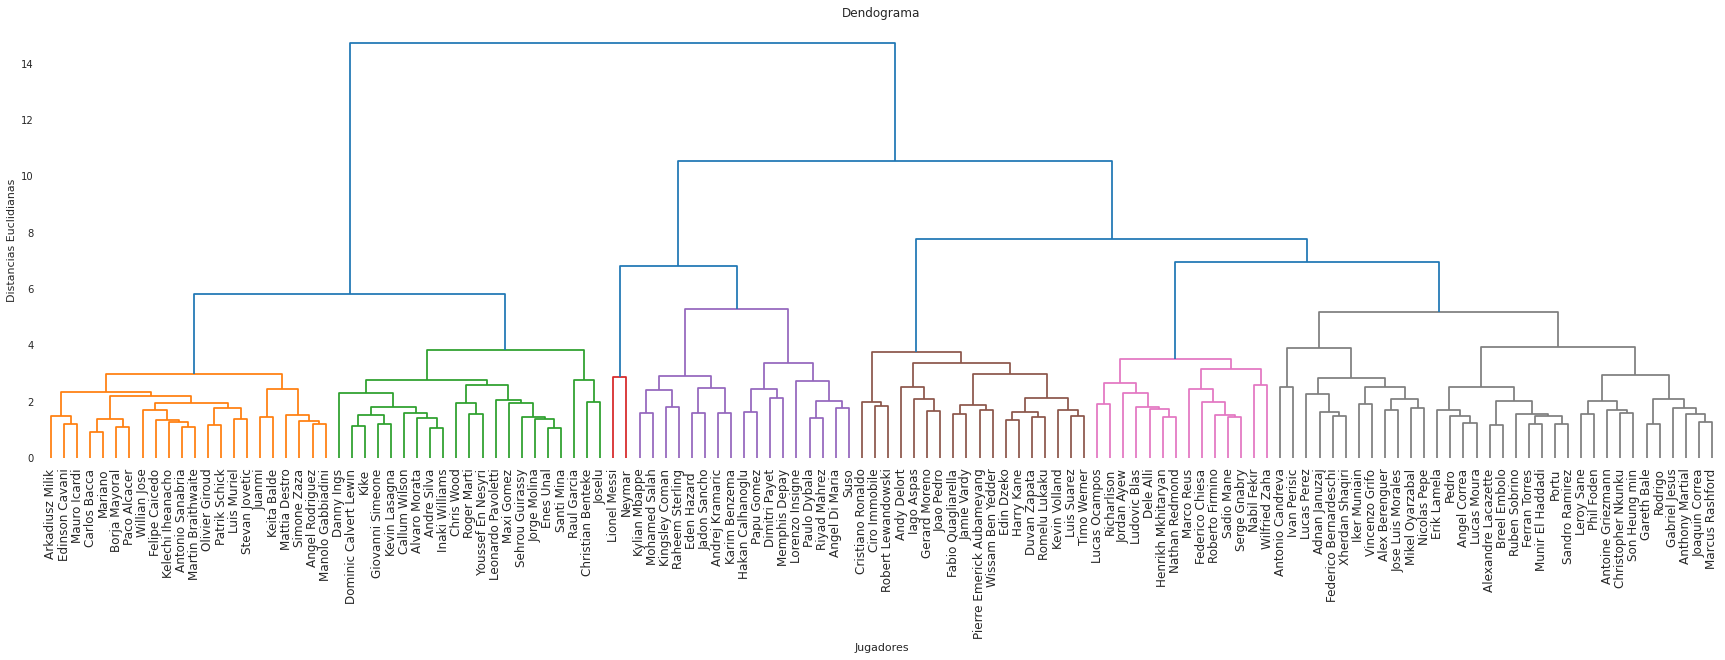

In [19]:
plt.figure(figsize=(30, 8))
plt.title('Dendograma')
plt.xlabel('Jugadores')
plt.ylabel('Distancias Euclidianas')
dendrogram = sch.dendrogram(sch.linkage(df_norm.values, method = 'ward'),
                            labels=df_norm.index, leaf_font_size=12.,
                            color_threshold=5.5)
plt.show()

## Segundo algoritmo

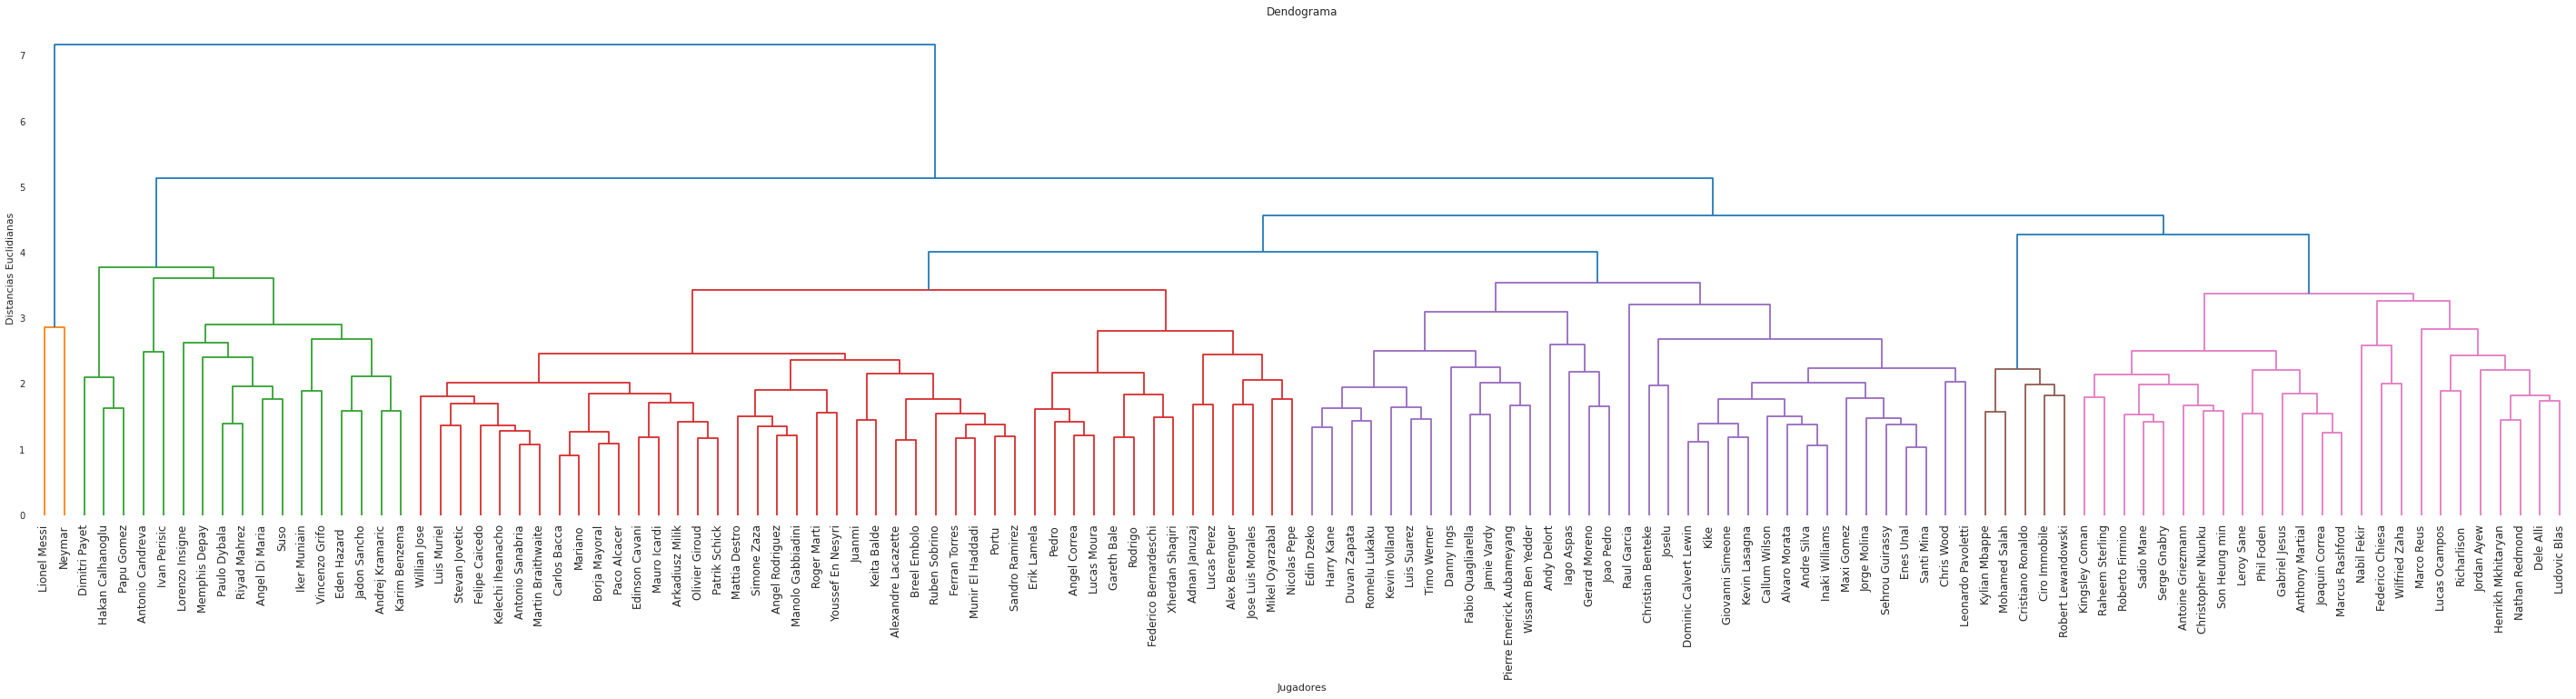

In [14]:
plt.figure(figsize=(50, 10))
plt.title('Dendograma')
plt.xlabel('Jugadores')
plt.ylabel('Distancias Euclidianas')
dendrogram = sch.dendrogram(sch.linkage(df_norm.values, method = 'complete'),
                            labels=df_norm.index, leaf_font_size=12.,
                            color_threshold=4)
plt.show()

## Tercer algoritmo

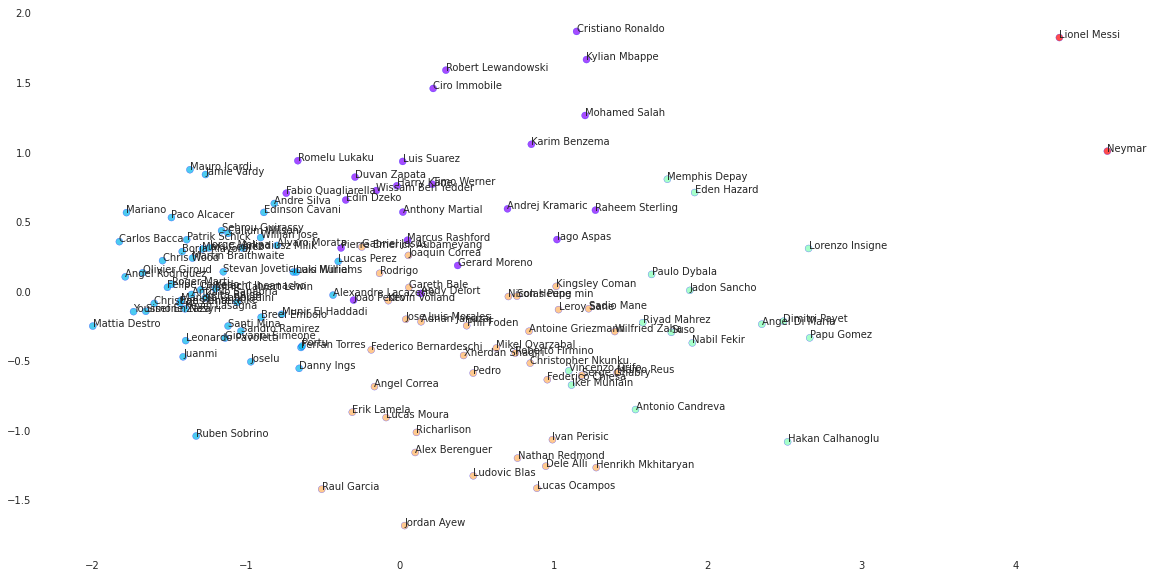

[0.39413702 0.10849694]


,StartPerc,Min,PK,Sh,SoT,npxG,TotCmp,TotDist,PrgDist,ShortCmp,...,TotCmpPerc,ShortCmpPerc,MedCmpPerc,LongCmpPerc,TklWPerc,TklDribPerc,PressPerc,SuccDribPerc,RecPassPerc,AerialDuelsPerc
PC1,0.100877,0.104044,0.050154,0.059603,0.052397,0.015667,0.154969,0.161776,0.145123,0.154969,...,0.088401,0.088401,0.088401,0.088401,0.011786,-0.046795,0.053886,0.054037,0.153592,-0.047914
PC2,0.071473,0.095164,0.196592,0.144416,0.171404,0.181275,0.003705,-0.015084,-0.028350,0.003705,...,0.032219,0.032219,0.032219,0.032219,0.050001,0.113174,0.004461,0.010085,-0.091363,0.022017


In [15]:
## K-MEANS
clustering = KMeans(n_clusters=5, random_state=1234).fit(df_norm)
# 2-COMPONENT PCA
pca = PCA(n_components=2, random_state=1234)
pca.fit(df_norm.values)
pca_vals = pca.transform(df_norm.values)
df_pca = pd.DataFrame(pca_vals, columns=['PC1','PC2'])
# PLOT K-MEANS
plt.figure(figsize=(20, 10))
plt.scatter(df_pca['PC1'], df_pca['PC2'], c=clustering.labels_, cmap='rainbow', 
            alpha=0.7, edgecolors='b')
for i, txt in enumerate(df_norm.index):
    plt.annotate(txt, (df_pca['PC1'][i], df_pca['PC2'][i]))
plt.show()
print(pca.explained_variance_ratio_)
df_comp = pd.DataFrame(pca.components_, columns=df_norm.columns, index=['PC1', 'PC2'])
df_comp

## Cuarto algoritmo

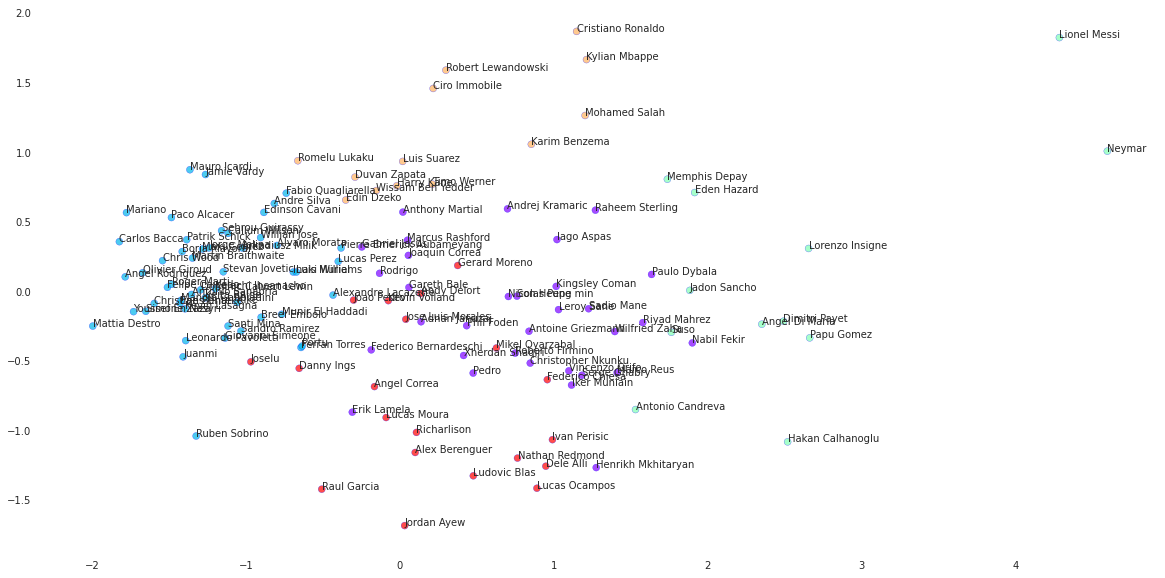

[0.39413702 0.10849694]


,StartPerc,Min,PK,Sh,SoT,npxG,TotCmp,TotDist,PrgDist,ShortCmp,...,TotCmpPerc,ShortCmpPerc,MedCmpPerc,LongCmpPerc,TklWPerc,TklDribPerc,PressPerc,SuccDribPerc,RecPassPerc,AerialDuelsPerc
PC1,0.100877,0.104044,0.050154,0.059603,0.052397,0.015667,0.154969,0.161776,0.145123,0.154969,...,0.088401,0.088401,0.088401,0.088401,0.011786,-0.046795,0.053886,0.054037,0.153592,-0.047914
PC2,0.071473,0.095164,0.196592,0.144416,0.171404,0.181275,0.003705,-0.015084,-0.028350,0.003705,...,0.032219,0.032219,0.032219,0.032219,0.050001,0.113174,0.004461,0.010085,-0.091363,0.022017


In [16]:
## GMM
gmm = GaussianMixture(n_components=5, random_state=1234).fit(df_norm.values)
labels = gmm.predict(df_norm.values)
## 2-COMPONENT PCA
pca = PCA(n_components=2, random_state=1234)
pca.fit(df_norm.values)
X_pca_array = pca.transform(df_norm.values)
X_pca = pd.DataFrame(X_pca_array, columns=['PC1','PC2'])
## PLOT GMM
plt.figure(figsize=(20, 10))
plt.scatter(X_pca['PC1'], X_pca['PC2'], c=labels, cmap='rainbow', 
            alpha=0.7, edgecolors='b')
for i, txt in enumerate(df_norm.index):
    plt.annotate(txt, (X_pca['PC1'][i], X_pca['PC2'][i]))
plt.show()
print(pca.explained_variance_ratio_)
df_comp = pd.DataFrame(pca.components_, columns=df_norm.columns, index=['PC1', 'PC2'])
df_comp

# Extra

Medir valor de la variable puntuación en los clusters. Datos de clusteres recogidos del algoritmo 1: Clustering Jerárquico con criterio de enlace Ward.

Cluster Rojo: Los dos mejores según la variable puntuación.
* Neymar: 2 
* Messi: 1

Cluster Marrón: Goleadores, no tan buen rendimiento en variable puntuación (5/19 en top 25)
* Ronaldo: 4
* Lewandowski: 7
* Immobile: 35
* Werner: 43
* Sterling: 17
* Andy Delort: 62
* Aspas: 24
* Gerard Moreno: 37
* Joao Pedro: 66
* Quagliarella: 76
* Vardy: 81
* Aubameyang: 60
* Ben-Yedder: 57 
* Dzeko: 38
* Kane: 25
* Zapata: 48
* Lukaku: 63
* Volland: 65
* Luis Suárez: 46


Cluster Morado: Regateadores, buen rendimiento en variable puntuación (13/17 en top 20)
* Mbappe: 3
* Salah: 6
* Coman: 28
* Sterling: 17
* Calhanoglu: 19
* Sancho: 10
* Benzema: 23
* Kramaric: 34
* Hazard: 8 
* Insigne: 9
* Payet: 18
* Depay: 13
* Papu: 5
* Di Maria: 12
* Dybala: 15
* Mahrez: 16
* Suso: 32

In [23]:
df_final_2 = df_new.merge(df_result, how='inner', on=['Player', 'Date']).drop(
    columns = ['Date', 'Day', 'Comp', 'Round', 'Venue', 'Squad', 'Opponent', 
               'Pos', 'TotCmpPerc', 'ShortCmpPerc', 'MedCmpPerc', 'LongCmpPerc', 
               'TklDrib', 'Squad_Goals', 'Opponent_Goals',
               'Gls', 'PKatt', 'xG', 'Att', 'InCK', 'OutCK', 'StrCK', 'Other', 
               'CmpPass', 'SCA', 'GCA', 'TklDribPerc', 'PressPerc', 
               'PassBlock', 'Tkl+Int', 'Touches', 'SuccDribPerc', 'RecPassPerc', 
               'AerialDuelsWinPerc', 'Result', 'Result_D']).fillna(0)
df_agg_2 = df_final_2.groupby(['Player']).mean().rename(
                   columns={'Result_L': 'LosePerc', 'Result_W': 'WinPerc',
                            'Start': 'StartPerc'})
df_agg_2['TotCmpPerc'] = df_agg_2['TotCmp']/df_agg_2['TotAtt']
df_agg_2['ShortCmpPerc'] = df_agg_2['ShortCmp']/df_agg_2['ShortAtt']
df_agg_2['MedCmpPerc'] = df_agg_2['MedCmp']/df_agg_2['MedAtt']
df_agg_2['LongCmpPerc'] = df_agg_2['LongCmp']/df_agg_2['LongAtt']
df_agg_2['TklWPerc'] = df_agg_2['TklW']/df_agg_2['Tkl']
df_agg_2['TklDribPerc'] = df_agg_2['TklDribPast']/df_agg_2['TklDribAtt']
df_agg_2['PressPerc'] = df_agg_2['PressSucc']/df_agg_2['PressAtt']
df_agg_2['SuccDribPerc'] = df_agg_2['SuccDrib']/df_agg_2['AttDrib']
df_agg_2['RecPassPerc'] = df_agg_2['RecPass']/df_agg_2['TargPass']
df_agg_2['AerialDuelsPerc'] = df_agg_2['AerialDuelsWon']/df_agg_2['AerialDuelsLost']
df_agg_2 = df_agg_2.drop(columns = ['TotAtt', 'ShortAtt', 'MedAtt', 'LongAtt', 
                                'Tkl', 'TklDribAtt', 'PressAtt', 'AttDrib', 
                                'TargPass', 'AerialDuelsLost'])
df_agg_2['Puntuacion'].sort_values(ascending=False)[:50]

Player
Lionel Messi          8.957042
Neymar                8.894462
Kylian Mbappe         7.600385
Cristiano Ronaldo     7.504217
Papu Gomez            7.492259
Mohamed Salah         7.454138
Robert Lewandowski    7.418122
Eden Hazard           7.403361
Lorenzo Insigne       7.402360
Jadon Sancho          7.350172
Nabil Fekir           7.337366
Angel Di Maria        7.317280
Memphis Depay         7.273750
Wilfried Zaha         7.273054
Paulo Dybala          7.243950
Riyad Mahrez          7.195641
Raheem Sterling       7.175960
Dimitri Payet         7.144296
Hakan Calhanoglu      7.100892
Sadio Mane            7.087933
Marco Reus            7.081957
Leroy Sane            7.075232
Karim Benzema         7.063549
Iago Aspas            7.042667
Harry Kane            7.021078
Serge Gnabry          7.013364
Son Heung min         6.995272
Kingsley Coman        6.988985
Federico Chiesa       6.963064
Nicolas Pepe          6.962173
Henrikh Mkhitaryan    6.952812
Suso                  6.917166
C